<div style="background-color: #04da79; border: 2px solid #039754; padding: 10px; color: black; font-family: Arial, Helvetica, sans-serif;">
    <strong>Kernel: Python 3 (ipykernel)
</div>

## Environment Setup

In [ ]:
%pip uninstall -y -q autogluon-multimodal autogluon-timeseries

In [ ]:
%pip install -Uq vllm==0.6.1 --extra-index-url https://download.pytorch.org/whl/cu121

In [ ]:
%pip install -Uq accelerate==1.0.1

In [ ]:
%pip install -Uq qwen-vl-utils qwen-vl-utils[decord]

In [ ]:
%pip install -Uq git+https://github.com/huggingface/transformers@21fac7abba2a37fae86106f87fcf9974fd1e3830

In [ ]:
%pip install -Uq sentencepiece==0.1.99

In [ ]:
%pip install -q pydantic==2.9

In [ ]:
%pip install -q glances[all] rich[jupyter] streamlit

In [ ]:
!sudo apt-get install -qq -y jq > /dev/null

In [ ]:
from IPython import get_ipython
get_ipython().kernel.do_shutdown(restart=True)

<div style="background-color: #f5aeba; border: 2px solid #610010; padding: 10px; color: black; font-family: Arial, Helvetica, sans-serif;">
    Wait for 2-4 seconds for the Kernel to <b>restart</b>
</div>

---
# Lab 01: Video-LLM, An Introduction

In this lab, you'll learn how to download a model from HuggingFace Hub - particularly [Qwen/Qwen2-VL-7B-Instruct](https://huggingface.co/Qwen/Qwen2-VL-7B-Instruct) - to run local LLM inference. Local LLM inference refers to running a large language model (LLM) on your own machine or server. This means the model and its computation happen entirely within your local environment (in this case the notebook's host `ml.g5.xlarge`).

---

In [ ]:
import os
import sys
import boto3
import torch
import sagemaker
import decord
from transformers import AutoProcessor
from vllm import LLM, SamplingParams
from qwen_vl_utils import process_vision_info
from sagemaker.model import Model

sys.path.append(os.path.dirname(os.getcwd()))
from utils.helpers import pretty_llm_print 

In [ ]:
region = boto3.Session().region_name
role = sagemaker.get_execution_role()
session = sagemaker.Session(boto_session=boto3.Session(region_name=region))
sm_client = boto3.client("sagemaker", region_name=region)

---
## Monitor Your Compute Usage

[Glances](https://nicolargo.github.io/glances/) is a cross-platform monitoring tool that provides a real-time overview of system metrics like CPU, memory, disk I/O, and network usage in one console. It's particularly useful for monitoring local compute resources within SageMaker Studio, helping identify bottlenecks and resource constraints.

Benefits of Using Glances in SageMaker Studio,
- **Real-Time Monitoring**: Tracks CPU, memory, and disk usage to spot potential constraints affecting SageMaker tasks.
- **Network & Disk I/O Insights**: Essential for data-intensive workloads, showing if speeds and utilization are adequate.
- **Process Management**: Identifies resource-intensive processes impacting compute performance.
- **Lightweight**: Minimal overhead, keeping compute resources focused on SageMaker tasks.
- **Alerts**: Configurable thresholds notify you of high resource usage, aiding proactive scaling and optimization.

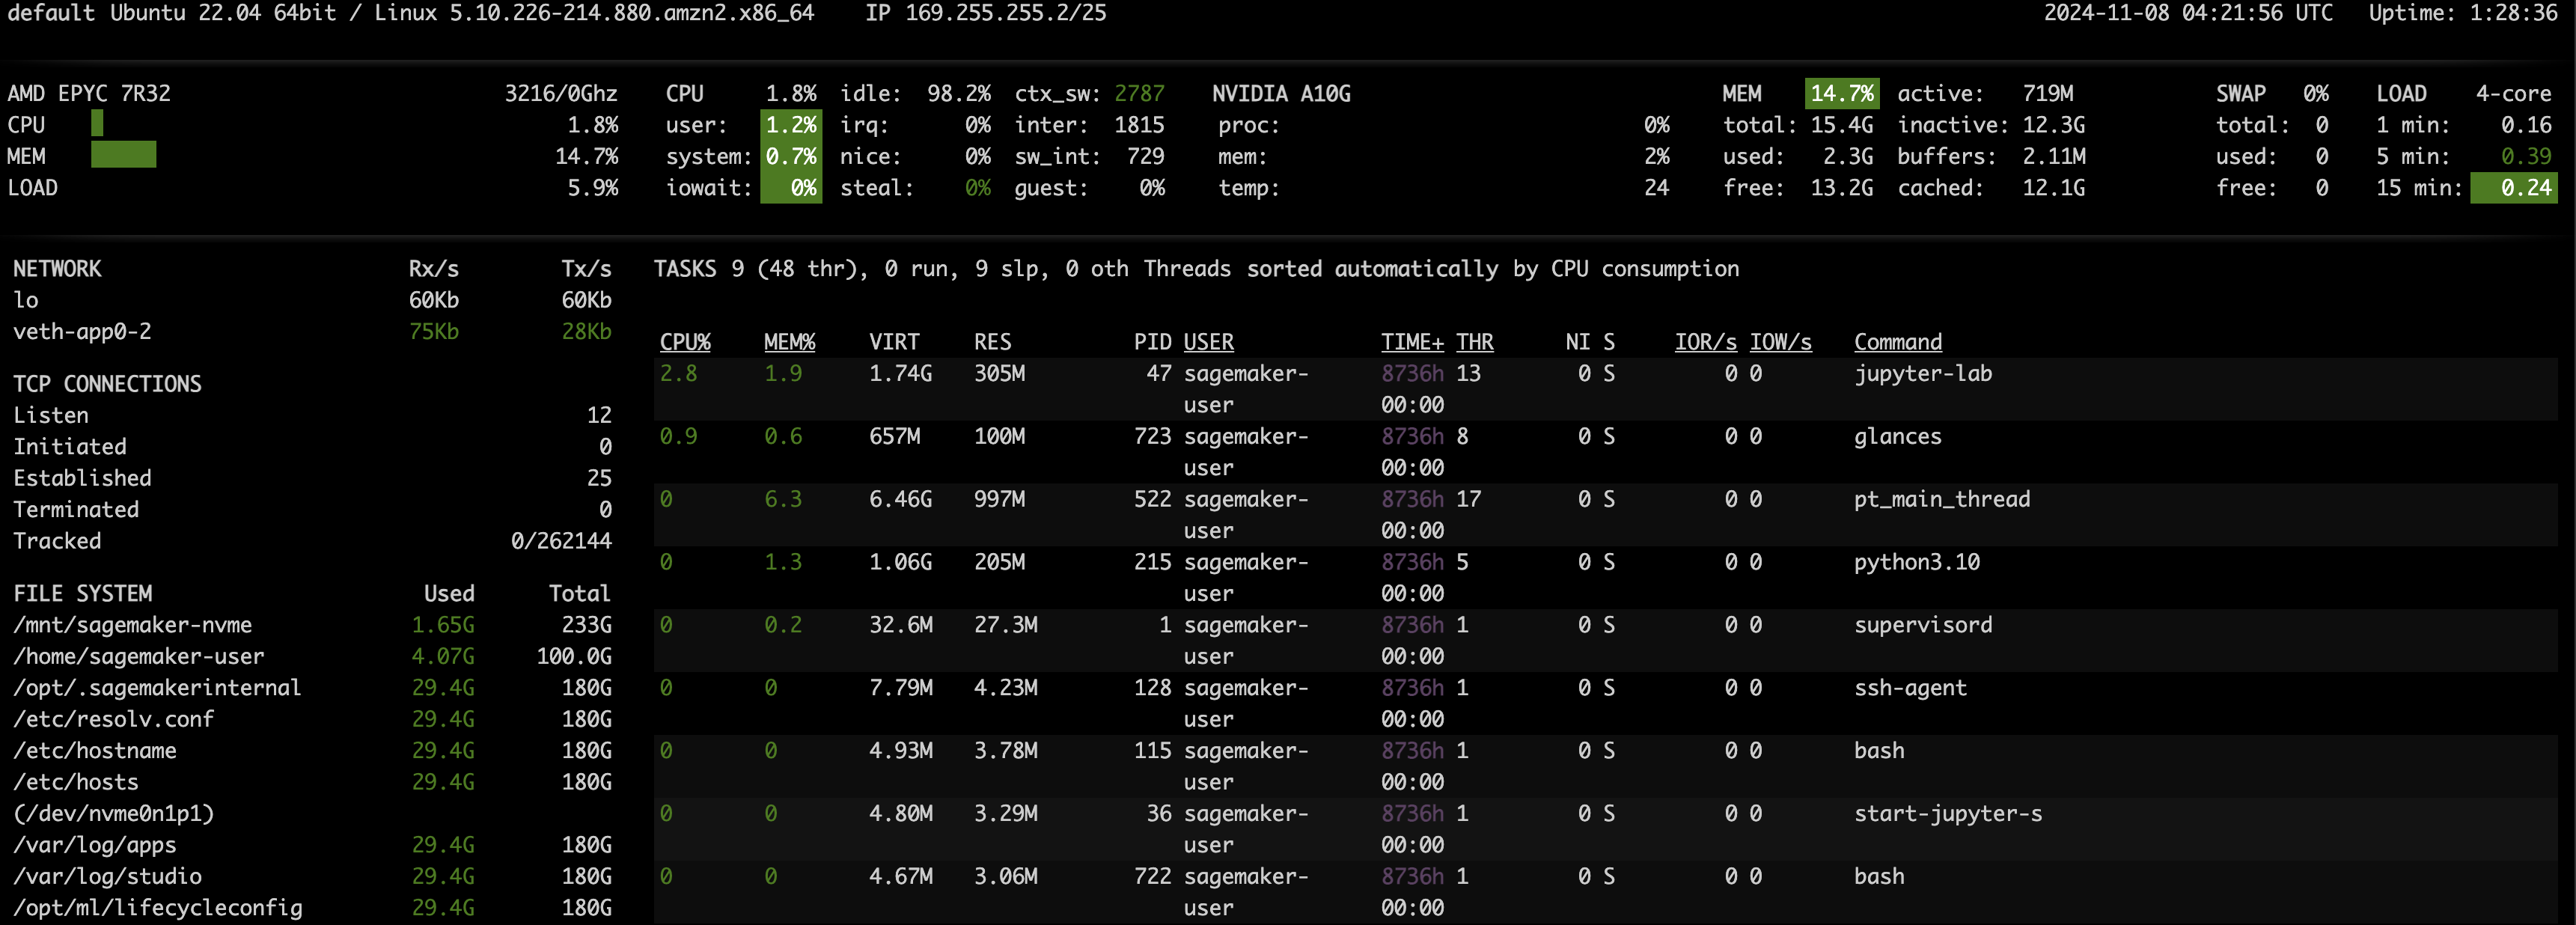

In [ ]:
%%bash

DOMAIN_ID=$(jq -r '.DomainId' /opt/ml/metadata/resource-metadata.json)
SPACE_NAME=$(jq -r '.SpaceName' /opt/ml/metadata/resource-metadata.json)
STREAMLIT_URL=$(aws sagemaker describe-space --domain-id $DOMAIN_ID --space-name $SPACE_NAME | jq -r '.Url')

nohup bash utils/run_glances_app.sh > glances.log 2>&1 &

sleep 2

echo "=====>  Launch Glances Monitor App: $STREAMLIT_URL/proxy/61208/"

## Local-LLM on GPU: `Qwen/Qwen2-VL-7B-Instruct`

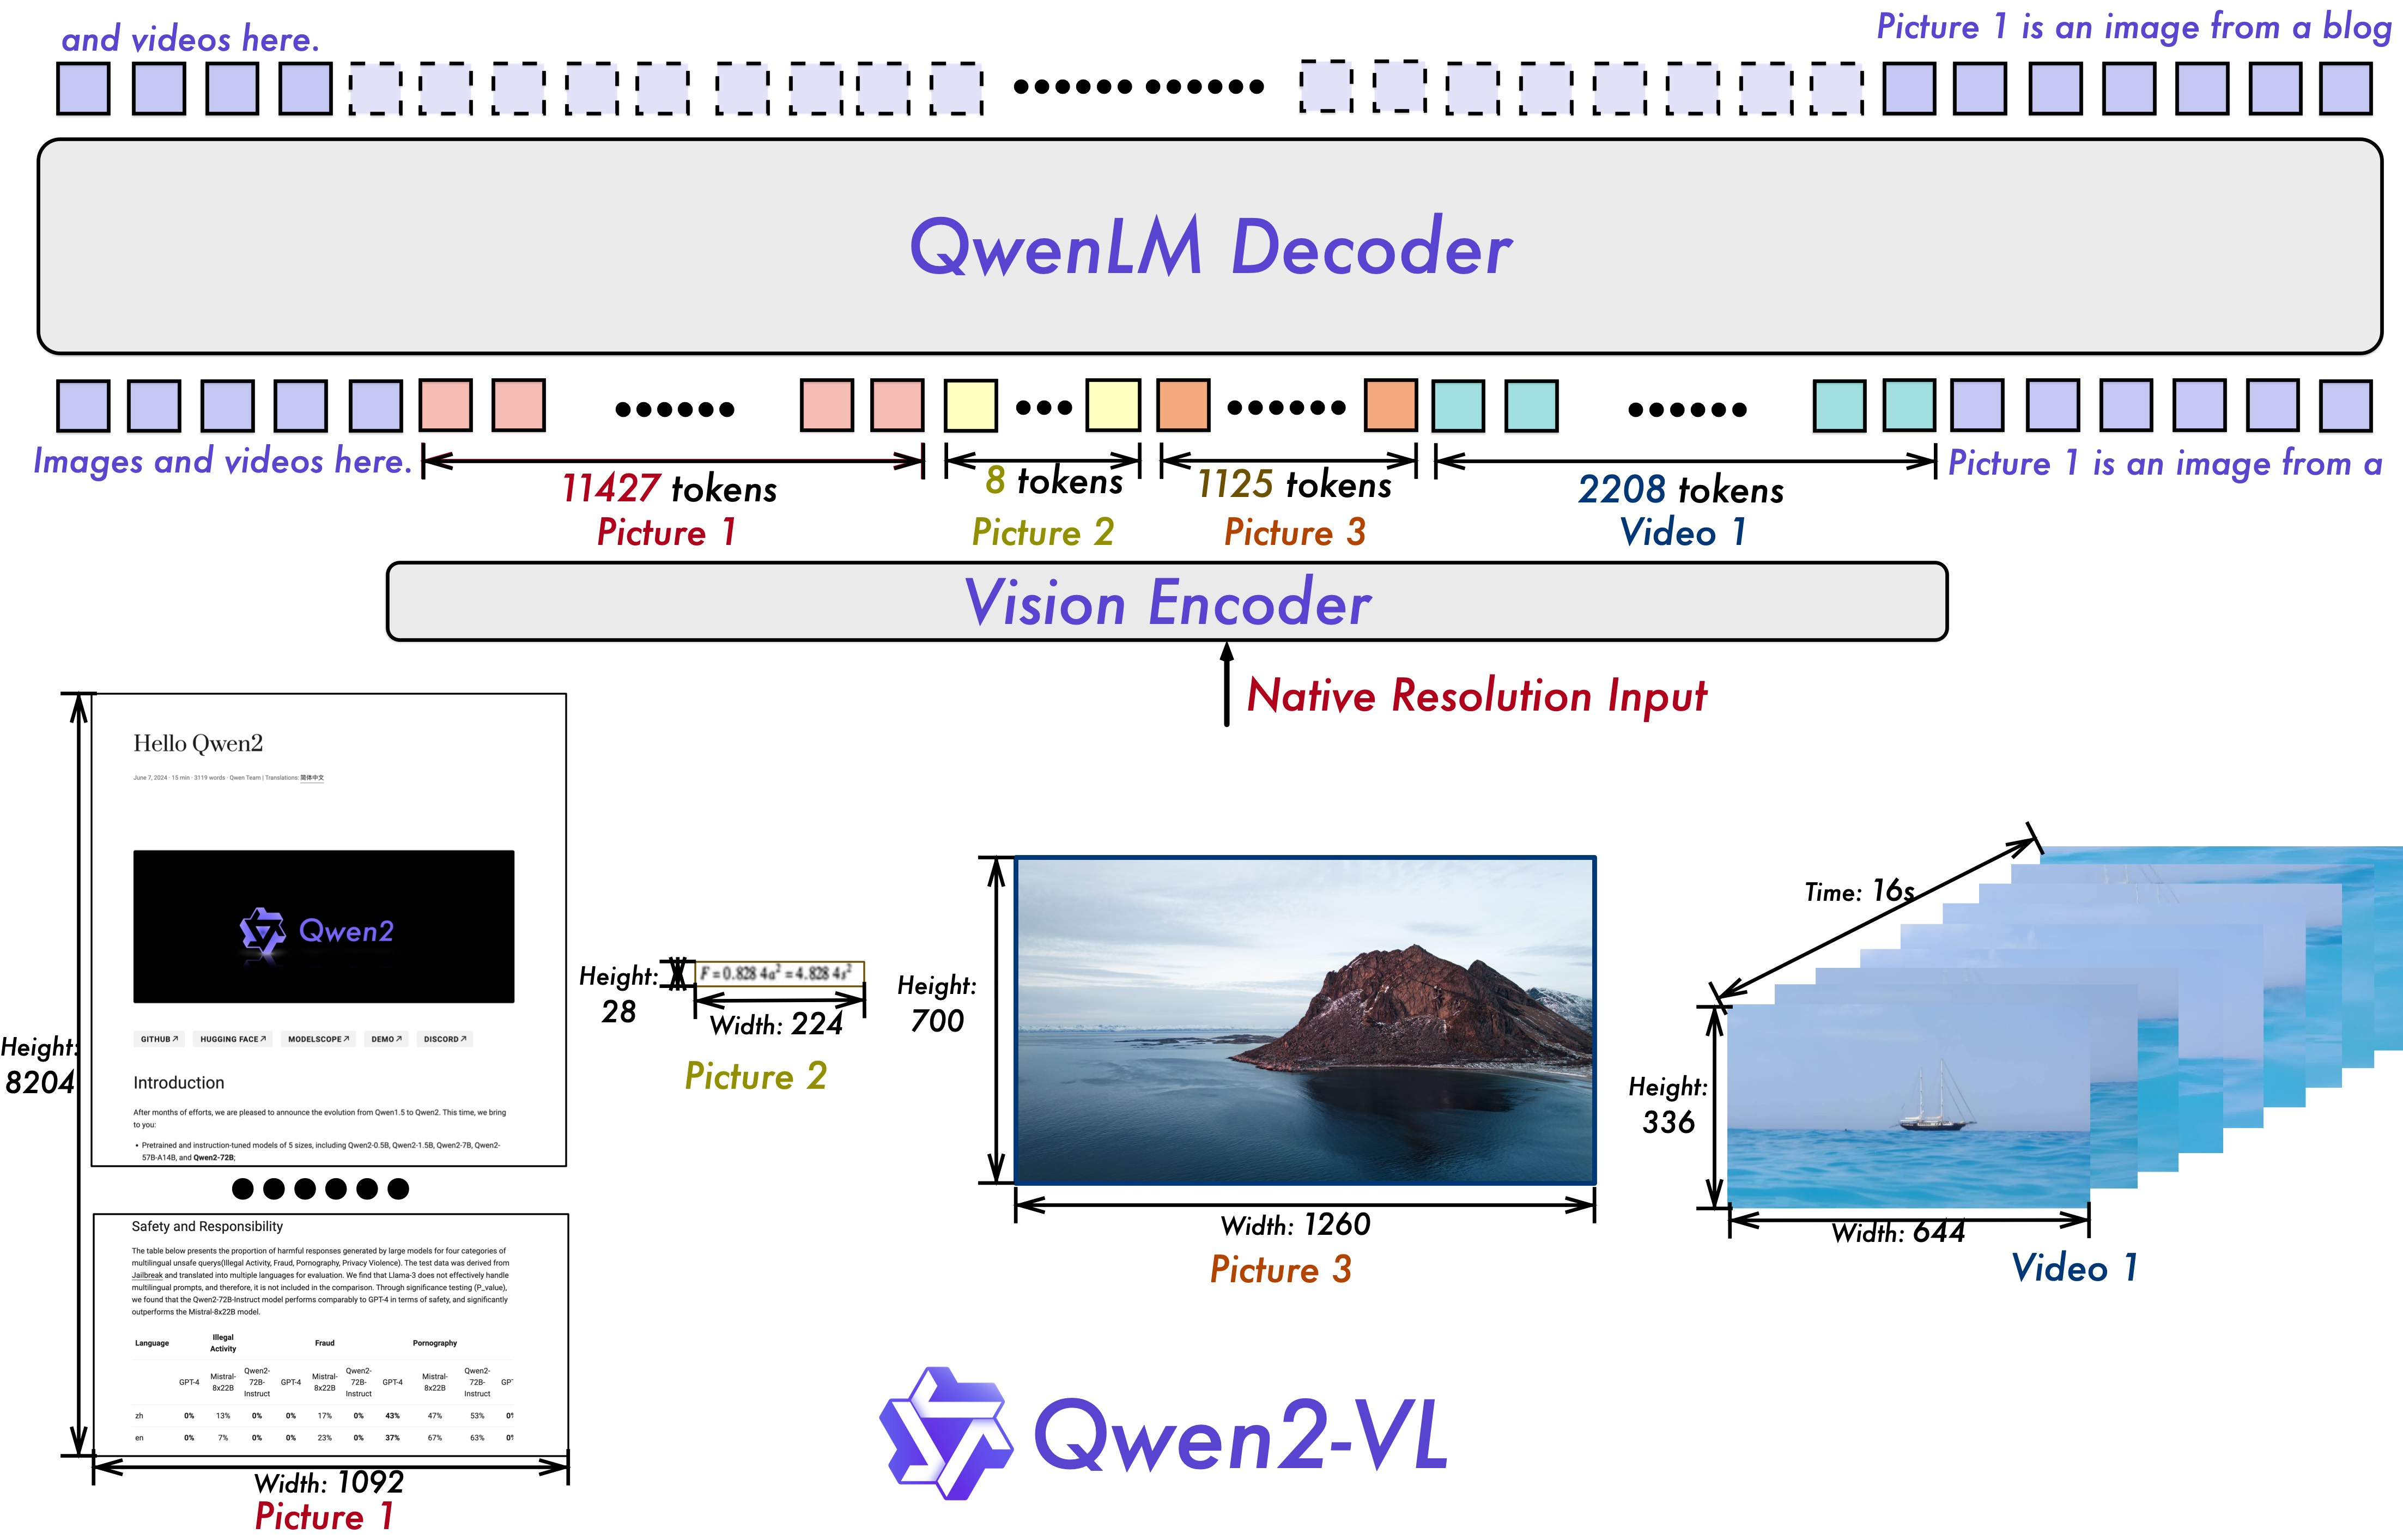

---
**👉 [Qwen/Qwen2-VL-7B-Instruct](https://huggingface.co/Qwen/Qwen2-VL-7B-Instruct) 👈**

Qwen2-VL is the latest iteration of the Qwen-VL model series. VL stands for Vision-Language [model]. It offers state-of-the-art understanding of images with various resolutions and ratios, achieving top performance on visual understanding benchmarks such as MathVista, DocVQA, RealWorldQA, and MTVQA. Additionally, Qwen2-VL can comprehend videos over 20 minutes in length, facilitating high-quality video-based question answering, dialogue, and content creation. The model also supports multilingual text recognition within images, including most European languages, Japanese, Korean, Arabic, and Vietnamese. 

- **SoTA understanding of images of various resolution & ratio**: Qwen2-VL achieves state-of-the-art performance on visual understanding benchmarks, including MathVista, DocVQA, RealWorldQA, MTVQA, etc.

- **Understanding videos of 20min+**: Qwen2-VL can understand videos over 20 minutes for high-quality video-based question answering, dialog, content creation, etc.

- **Agent that can operate your mobiles, robots, etc.**: with the abilities of complex reasoning and decision making, Qwen2-VL can be integrated with devices like mobile phones, robots, etc., for automatic operation based on visual environment and text instructions.

- **Multilingual Support**: to serve global users, besides English and Chinese, Qwen2-VL now supports the understanding of texts in different languages inside images, including most European languages, Japanese, Korean, Arabic, Vietnamese, etc.

- **Naive Dynamic Resolution**: Unlike before, Qwen2-VL can handle arbitrary image resolutions, mapping them into a dynamic number of visual tokens, offering a more human-like visual processing experience.

---

If you're using a `ml.g5.xlarge` you will have a `A10G 24 GB` GPU. Which mean you could possible load a `7 billion to 10 billion` parametric model at `half`, `float16` or `bfloat16` format.

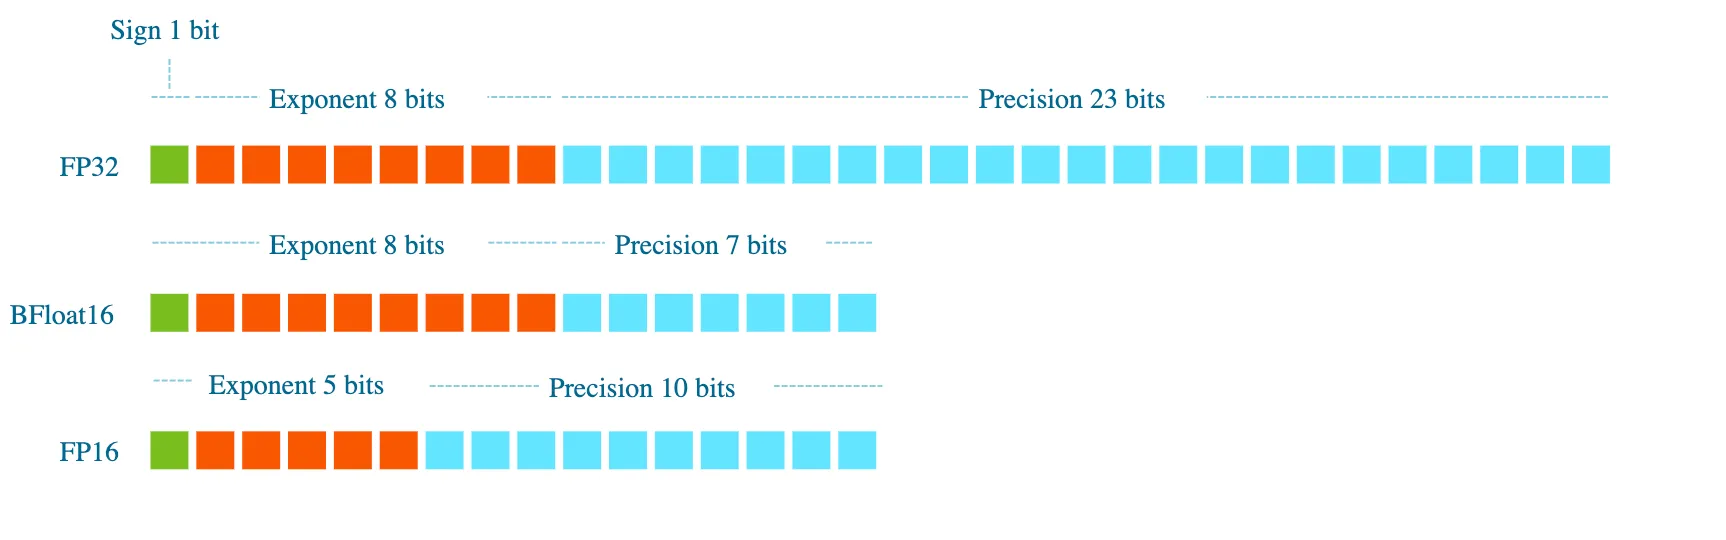

- **dtype** – The data type for the model weights and activations. Currently, we support float32, float16, and bfloat16. If auto, we use the torch_dtype attribute specified in the model config file. However, if the torch_dtype in the config is float32, we will use float16 instead.
- **limit_mm_per_prompt** - To enable multiple multi-modal items per text prompt, you have to set this as a `dict` of `{'image':.., 'video':..}`
- **gpu_memory_utilization** - Limits the GPU memory utilization when loading a model into memory - adjust this parameter based on model to max-prompt size estimate ratio
- **max_model_len** - The max_model_len parameter in the vLLM class defines the maximum number of tokens the model can process in a single sequence, ensuring inputs align with the model's training limits and hardware constraints. It prevents memory overload, optimizes performance, and guarantees compatibility with the model's architecture.
- **enforce_eager**: The enforce_eager parameter in the vLLM class ensures that the model executes operations in "eager execution" mode rather than deferred or lazy execution. This is useful for debugging or cases where immediate feedback from computations is required, as it forces the system to evaluate operations step-by-step instead of building an execution graph to be run later.

In [ ]:
video_llm_model_id = "Qwen/Qwen2-VL-7B-Instruct"
max_images_per_prompt = 2
max_videos_per_prompt = 1
dtype = "half"
gpu_memory_utilization = 0.95
max_model_len = 12000
enforce_eager = False

---
**How is `vllm.LLM` class different from `transformers` for model loading?**

The `vllm.LLM` method differs from `transformers` in its underlying architecture and intended use case. While `transformers` provides a direct way to load and interact with a model (e.g., `Qwen2VLForConditionalGeneration`) with pre-defined methods for tasks like conditional generation, `vllm.LLM` is designed for optimized inference, particularly for large-scale deployments. vLLM employs a memory-efficient approach using a token stream scheduler and other inference optimizations, enabling faster generation and better scalability compared to the more general-purpose `transformers` library. This makes `vllm.LLM` better suited for high-performance, low-latency applications where throughput is critical, whereas `transformers` offers greater flexibility for development and experimentation.

---

In [ ]:
%%time 
llm = LLM(
    model=video_llm_model_id,
    limit_mm_per_prompt={
        "image": max_images_per_prompt, 
        "video": max_videos_per_prompt
    },
    gpu_memory_utilization=gpu_memory_utilization,
    max_model_len=max_model_len,
    tensor_parallel_size=1,
    dtype=dtype,
    enforce_eager=enforce_eager
)

In the context of large language models (LLMs), a **processor** is a helper tool that prepares your input data (like text, images, or videos) into a format the model can understand and process. Think of it as a translator that converts raw data into "tokens" or representations that the model uses for calculations.

- The `AutoProcessor` automatically picks the right type of processor for the specified model (`video_llm_model_id`).
- If your model works with video data, the processor might extract frames from the video, resize them, and normalize pixel values.
- It ensures the input matches the requirements of the model architecture (e.g., sequence lengths, embeddings).

This makes it easier for developers because they don’t need to handle all these preprocessing steps manually. Instead, the processor handles everything in the background so you can focus on working with your data and the model outputs.

In [ ]:
%%time
processor = AutoProcessor.from_pretrained(
    video_llm_model_id
)

---
## Local LLM

Most important model generation parameters,

**temperature**: The temperature is a parameter that controls the randomness of an LLM’s output. A higher temperature will result in more creative and imaginative response, while a lower temperature will result in more accurate and factual text. Use higher temperature for non-deterministic tasks.

**top_p**: Top-p sets a cumulative probability threshold retaining tokens with a total probability above it.  

**top_k**: Top-k selects the top-k most likely tokens, ensuring high-quality output. 

Top-k is useful for avoiding nonsensical responses, while Top-p can ensure diversity. For example, if you set Top-k to 10, the LLM will only consider the 10 most probable next words. This will result in more fluent text, but it will also reduce the diversity of the text. If you set Top-p to 0.9, the LLM will only generate words that have a probability of at least 0.9. This will result in more diverse text, but it could also result in less fluent text.

**repetition_penalty**: Repetition Penalty penalizes the LLM for generating words that are frequently used. This can be useful for preventing the LLM from generating repetitive text.

**max_tokens**: Max tokens refers to the size of output generated text. This is a combination of input tokens + output generation tokens. This parameter is different from `max_new_tokens` which only focuses on a count of output tokens to generate.

---

In [ ]:
sampling_params = SamplingParams(
    temperature=0.1,
    top_p=0.001,
    repetition_penalty=1.05,
    max_tokens=256,
    stop_token_ids=[],
)

Qwen uses a `system`/`user`/`assistant` format, which greatly simplifies communication with the model.

In [ ]:
messages = [
    {
        "role": "system", 
        "content": "You are a helpful assistant."
    },
    {
        "role": "user",
        "content": [
            {
                "type": "text", 
                "text": "Write a sonnet about Machine Learning and Amazon SageMaker?"
            }
        ],
    }
]

A `Qwen2-VL` model does not understand a `List` or a `List[Dict]` with `role` structure in it but instead understands a prompt format as below,

```
'<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\nWrite a sonnet about Machine Learning and Amazon SageMaker?<|im_end|>\n<|im_start|>assistant\n'
```

Its difficult for us to remember special characters like `<|im_start|>` or `<|im_end|>`, instead have a built-in `processor.apply_chat_template` format that automatically allows us to apply a model's training chat template in a defined and structured format.

In [ ]:
prompt = processor.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
)

Qwen also has `process_vision_info` function - this will automatically extract `image` and `video` data and formats it into numpy array to feed back into the model.

In [ ]:
image_inputs, video_inputs = process_vision_info(messages)

---
**Putting it all together**

We have our text prompt and we have our multi-modal data (as arrays). Next, we combine all this into a single dictionary to enable our model to generate output as text


In [ ]:
mm_data = {}
if image_inputs is not None:
    mm_data["image"] = image_inputs
if video_inputs is not None:
    mm_data["video"] = video_inputs

llm_inputs = {
    "prompt": prompt,
    "multi_modal_data": mm_data,
}

In [ ]:
outputs = llm.generate(
    [llm_inputs], 
    sampling_params=sampling_params
)
generated_text = outputs[0].outputs[0].text
messages.append({"role": "assistant", "content": generated_text})

In [ ]:
pretty_llm_print(messages, title=video_llm_model_id)

---
---

# Lab 02: Text, Image and Video Prompt Engineering

Once you've learnt to download, instantiate and communicate with a Vid-LLM model, the next step is to learn how to get the model to do some facinating things with the help of Prompt Engineering tactics. You might be aware of existing Simple to Advanced Prompt Engineering topics like Zero Shot, Few Shot, Chain of Thought and much more. Vid-LLMs responses can be crafted using these techniques however, there's an added layer of complexity in the form of multi-modal inputs. With Qwen2-VL supporting text, images and video modalities it opens up the possibilities and use cases. In this notebook we're going to explore some of those use cases. 

---

## Prompt Engineering with Video-LLMs

Prompt engineering is the process of crafting and refining prompts to effectively guide a large language model (LLM) in generating accurate and contextually relevant responses. For traditional LLMs, prompt engineering often involves providing clear, concise instructions and context to elicit specific outputs from text-based inputs. This process may include using structured prompts, detailed instructions, or examples to optimize the LLM’s understanding and performance on a given task.

In contrast, prompt engineering for multi-modal LLMs, which handle both text and non-text inputs like images or videos, requires a more complex approach. It must account for the alignment and interaction between different data types, ensuring that the LLM interprets and integrates information across modalities accurately. For example, prompts for multi-modal models may involve describing visual elements in text to guide the model’s understanding of images or sequences in video content, making the prompt engineering process more nuanced and multi-dimensional.

---

In [ ]:
from PIL import Image
import base64
import io
from typing import List, Dict

The function below just compresses what we've already done in the previous lab and simplifies into a function so you can write once and use many times. This function takes in a message in `system`/`user`/`assistant` format and returns a `Qwen2-VL` prompt format.

In [ ]:
def build_multi_modal_prompt(message: List[Dict]) -> Dict: 
    """ 
    Takes in the input message, which is List[Dicts] structure and 
    returns formatted prompt with multimodal inputs
    """
    prompt = processor.apply_chat_template(
        message,
        tokenize=False,
        add_generation_prompt=True,
    )
    image_inputs, video_inputs = process_vision_info(message)
    mm_data = {}
    if image_inputs is not None:
        mm_data["image"] = image_inputs
    if video_inputs is not None:
        mm_data["video"] = video_inputs
    llm_inputs = {
        "prompt": prompt,
        "multi_modal_data": mm_data,
    }
    return llm_inputs

### Example 1: Text to Text Generation
---
Before we jump right into Video inference, let's set the stage to try and understand how Qwen's prompts works ina simple text to text scenario. This is where we can test the basic performance of a `Qwen2-VL` model for most common tasks like QnA, Summarization, etc. 

---

In [ ]:
messages_sample1 = [
    {
        "role": "system", 
        "content": "You are a helpful assistant."
    },
    {
        "role": "user",
        "content": [
            {
                "type": "text", 
                "text": "Write a sonnet about Amazon SageMaker?"
            },
        ],
    },
]

In [ ]:
llm_input_sample1 = build_multi_modal_prompt(messages_sample1)

In [ ]:
outputs = llm.generate(
    [llm_input_sample1], 
    sampling_params=SamplingParams(
        temperature=0.1,
        top_p=0.001,
        repetition_penalty=1.05,
        max_tokens=256,
        stop_token_ids=[]
    )
)
generated_text = outputs[0].outputs[0].text
messages_sample1.append({"role": "assistant", "content": generated_text})

In [ ]:
pretty_llm_print(messages_sample1, title=video_llm_model_id)

### Example 2: Image, Text to Text
---
Once we're familiar with a simple text-to-text format. Now let's add an image into the model's prompt. There are 3 ways to include images in Qwen model's prompt

1. Image file path - if image is locally availble with `file://path/to/image.jpg`
2. Image HTTP/HTTPS URL - include image URL path directly without downloading the image to disk - ensure this filepath isn't locked behind a firewall/paywall
3. **Image as Base64 Encoding** - The most reliable way is to run client side image processing and send media as base64 encoded string for Qwen's processing. This needs to be included as `"data:image/png;base64,{encoded_image_text}"` for Qwen to recognize these images.

We'll choose **#3** for this workshop.

---

In [ ]:
def resize_and_encode_image(image_path, resolution=None):
    """Takes in an image path and return a image encoded as str"""
    with Image.open(image_path) as img:
        if resolution:
            img_resized = img.resize(resolution)
        else:
            img_resized = img
        buffered = io.BytesIO()
        img_resized.save(buffered, format="PNG")
        encoded_image = base64.b64encode(buffered.getvalue())
        encoded_image_text = encoded_image.decode("utf-8")
        base64_str = f"data:image/png;base64,{encoded_image_text}"
        return base64_str, img_resized

Take a sample image from this repository (or any image you like) and read it into memory. Downstream we'll see how to send this image to a model as prompt.

In [ ]:
image_path = "sample-media/sample-image-eifel-tower.jpeg"
encoded_image, img_pil = resize_and_encode_image(image_path, resolution=None)
img_pil.resize((640, 480))

Notice how we feed images into the model,
1. We use **system** to govern the high-level behavior of the model
2. Images, user prompt, videos are fed in the content section of Qwen's prompt
3. Qwen2-VL prompt supports a set of control parameters like `resized_height/width` which allows `Qwen2-VL` to run resizing internally

In [ ]:
messages_sample2 = [
    {
        "role": "system", 
        "content": "You are a helpful assistant."
    },
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": encoded_image,
                "resized_height": 640,
                "resized_width": 960,
            },
            {
                "type": "text", 
                "text": "Describe this image in sufficient detail."
            }
        ]
    }
]

In [ ]:
llm_input_sample2 = build_multi_modal_prompt(messages_sample2)
outputs = llm.generate(
    [llm_input_sample2], 
    sampling_params=SamplingParams(
        temperature=0.1,
        top_p=0.001,
        repetition_penalty=1.05,
        max_tokens=256,
        stop_token_ids=[]
    )
)
generated_text = outputs[0].outputs[0].text
messages_sample2.append({"role": "assistant", "content": generated_text})

In [ ]:
pretty_llm_print(messages_sample2, title=video_llm_model_id)

#### Asking follow-ups

What if we had a follow up questions on an image presented to Qwen? It's easy to ask follow on questions simply by adding model's response to the conversation chain and then followed up with a `user` prompt to get your follow-on questions answered as following,


In [ ]:
messages_sample2.append(
    {
        "role": "user", 
        "content": [
            {
                "type": "text", 
                "text": "Who constructed this and when was it constructed?"
            },
        ]
    }
)

In [ ]:
llm_input_sample2 = build_multi_modal_prompt(messages_sample2)
outputs = llm.generate(
    [llm_input_sample2], 
    sampling_params=SamplingParams(
        temperature=0.1,
        top_p=0.001,
        repetition_penalty=1.05,
        max_tokens=256,
        stop_token_ids=[]
    )
)
generated_text = outputs[0].outputs[0].text
messages_sample2.append({"role": "assistant", "content": generated_text})

In [ ]:
pretty_llm_print(messages_sample2, title=video_llm_model_id)

### Example 3: Multi-Image, Text to Text

---
Qwen supports multi-image inference out of the box. You can provide multiple images and ask relevant questions, and the model understands image context and answers without extensive prompt optimization. One common use case we chose for multi-image inference is to identify similarities or differences between two images by posing questions to Qwen. To showcase Qwen's strengths, we asked a philosophical question using two images of vehicles driving in the countryside, and the model effectively picked up on the theme.

**Bonus**: All images supplied in model prompt do not need a standard image resolution format. Images with different resolutions will be handled by Qwen out of the box.

---

In [ ]:
image_1_path = "sample-media/bikers-on-the-highway.jpg"
image_2_path = "sample-media/cars-on-the-highway.jpg"
encoded_image_1, img_pil_1 = resize_and_encode_image(image_1_path, resolution=None)
encoded_image_2, img_pil_2 = resize_and_encode_image(image_2_path, resolution=None)

In [ ]:
# Get the dimensions of each image
width1, height1 = img_pil_1.size
width2, height2 = img_pil_2.size
show_image = Image.new("RGB", ((width1 + width2), (max(height1, height2))))

# Paste image1 and image2 into the new image
show_image.paste(img_pil_1, (0, 0))
show_image.paste(img_pil_2, (width1, 0))  # Offset image2 to the right

# Display the result
show_image.resize((1280, 720)).show()

In [ ]:
messages_sample3 = [
    {"role": "system", "content": "You are a helpful assistant."},
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": encoded_image_1,
                "resized_height": 640,
                "resized_width": 960,
            },
            {
                "type": "image",
                "image": encoded_image_2,
                "resized_height": 640,
                "resized_width": 960,
            },
            {
                "type": "text", 
                "text": "Analyze the 2 images provided to you and describe the similarities or commonalities between the 2 images."
            },
        ],
    },
]

In [ ]:
llm_input_sample3 = build_multi_modal_prompt(messages_sample3)
outputs = llm.generate(
    [llm_input_sample3], 
    sampling_params=SamplingParams(
        temperature=0.1,
        top_p=0.001,
        repetition_penalty=1.05,
        max_tokens=256,
        stop_token_ids=[]
    )
)
generated_text = outputs[0].outputs[0].text
messages_sample3.append({"role": "assistant", "content": generated_text})

In [ ]:
pretty_llm_print(messages_sample3, title=video_llm_model_id)

### Example 4: Video, Text to Text
---
In this section of the notebook, we demonstrate how to natively send video as input to Qwen for inference. Most LLMs support `video` inference by processing a sequence of images, without actually being trained on video sequences. Does this make a difference? Yes. Although video is essentially a sequence of frames, models trained on sequences generally perform much better than those asked to infer or caption videos using only a sequence of images as input. Qwen supports video input out of the box, allowing you to provide native video as input and receive text as output. Like image input, video input is supported in three formats.

1. Video file path - if video is locally availble with `file://path/to/video.mp4`
2. Video HTTP/HTTPS URL - include video URL path directly without downloading the image to disk - ensure this filepath isn't locked behind a firewall/paywall
3. **Video as Base64 Encoding** - The most reliable way is to run client side image processing and send video as a list of base64 encoded strings for Qwen's processing. This needs to be included as `"data:image/png;base64,{encoded_image_text}"` for Qwen to recognize these images.

Once again we're going to choose **# 3**.

---

In [ ]:
import decord
import numpy as np
from decord import VideoReader, cpu
from PIL import Image
from tqdm import tqdm
from IPython.display import Video

In [ ]:
def process_video(video_path, n=3, width=640, height=480, chunk_duration=3):
    """
    Process a video by sampling frames and organizing them into chunks.

    Parameters:
    - video_path (str): Path to the video file.
    - n (int): Number of frames to sample per second.
    - width (int): Desired width of the output frames.
    - height (int): Desired height of the output frames.
    - chunk_duration (int): Duration of each chunk in seconds.

    Returns:
    - dict: A dictionary where keys are chunk identifiers and values are lists of processed frames.
    """
    # Initialize VideoReader
    vr = VideoReader(video_path, ctx=cpu(0))
    
    # Get video properties
    total_frames = len(vr)
    fps = vr.get_avg_fps()
    duration = total_frames / fps
    frames_per_second = int(fps)
    
    # Initialize dictionary to store frames
    frames_dict = {}
    
    # Calculate the number of chunks
    num_chunks = int(np.ceil(duration / chunk_duration))
    
    # Iterate over each chunk
    for chunk_idx in tqdm(range(num_chunks)):
        chunk_start_sec = chunk_idx * chunk_duration
        chunk_end_sec = min((chunk_idx + 1) * chunk_duration, duration)
        chunk_key = f'video chunk {chunk_idx} ({chunk_start_sec:.2f}s to {chunk_end_sec:.2f}s)'
        frames_dict[chunk_key] = []
        
        # Calculate frame indices for the current chunk
        start_frame = int(chunk_start_sec * frames_per_second)
        end_frame = int(min(chunk_end_sec * frames_per_second, total_frames))
        frame_indices = np.linspace(start_frame, end_frame - 1, n * chunk_duration, endpoint=True, dtype=int)
        
        # Retrieve and process frames
        for idx in frame_indices:
            frame = vr[idx].asnumpy()
            # Resize frame using PIL
            image = Image.fromarray(frame)
            buffered = io.BytesIO()
            img_resized = image.resize((width, height))
            img_resized.save(buffered, format="PNG")
            encoded_image = base64.b64encode(buffered.getvalue())
            encoded_image_text = encoded_image.decode("utf-8")
            base64_str = f"data:image/png;base64,{encoded_image_text}"
            frames_dict[chunk_key].append(base64_str)
    
    return frames_dict

Let's ask Qwen to describe this alexa ad for us,

In [ ]:
video_path = './sample-media/amazon-alexa-echo-dot-advert.mp4'
Video(video_path, width=400, height=300)

Its ok to ignore `[h264 @ 0x563b1fe54f40] mmco: unref short failure`

In [ ]:
frames_data = process_video(
    video_path, 
    n=3, 
    width=400, 
    height=300, 
    chunk_duration=30
)

In [ ]:
video_responses = {}
for frames_key in tqdm(frames_data, desc="Processing Video Frames"):
    video_frames = frames_data[frames_key]
    user_prompt = """You are provided with a video, describe the video in sufficient detail. 
    Be sure to describe the actions that are taking place, any renowed names and entities in this video.
    """
    messages_sample4 = [
        {"role": "system", "content": "You are a helpful video assistant."},
        {
            "role": "user",
            "content": [
                {
                    "type": "video",
                    "video": video_frames,
                    "fps": 3.0,
                },
                {
                    "type": "text", 
                    "text": user_prompt
                },
            ],
        }
    ]
    llm_input_sample4 = build_multi_modal_prompt(messages_sample4)
    outputs = llm.generate(
        [llm_input_sample4], 
        sampling_params=SamplingParams(
            temperature=0.1,
            # top_p=0.001,
            repetition_penalty=1.05,
            max_tokens=8000,
            stop_token_ids=[]
        )
    )
    generated_text = outputs[0].outputs[0].text
    video_responses[frames_key] = generated_text

In [ ]:
generated_text_aggr = "\n\n".join([f"**{k}**:\n{video_responses[k]}" for k in video_responses])
messages_sample4.append({"role": "assistant", "content": generated_text_aggr})
pretty_llm_print(messages_sample4, title=video_llm_model_id)

### Example 5: Video, Image, Text to Text

---
In the final prompt example, we combine video and image inputs to maximize the model's capabilities. A common use case for this combination is video search.

For instance, if we have a product, like an Amazon Echo, and want to determine if this object appears anywhere in a video clip, we can now achieve this by simply passing both the image and video to Qwen and asking the question.

---

In [ ]:
target_image_path = "sample-media/echo-dot.jpeg"
encoded_target_image, img_target_pil = resize_and_encode_image(target_image_path, resolution=None)
img_target_pil

In [ ]:
video_responses = {}
for frames_key in tqdm(frames_data, desc="Processing Video Frames"):
    video_frames = frames_data[frames_key]
    user_prompt = """You are provided with a video and a reference image. 
    Can you tell me if the object in the image is present in the video? If so describe when and where  you see this in the video?
    """
    messages_sample5 = [
        {"role": "system", "content": "You are a helpful video assistant. You are responsible for analyzing the video and providing detailed information for users requests."},
        {
            "role": "user",
            "content": [
                {
                    "type": "video",
                    "video": video_frames,
                    "fps": 3.0,
                },
                {
                    "type": "image",
                    "image": encoded_target_image,
                },
                {
                    "type": "text", 
                    "text": user_prompt
                },
            ],
        }
    ]
    llm_input_sample5 = build_multi_modal_prompt(messages_sample5)
    outputs = llm.generate(
        [llm_input_sample5], 
        sampling_params=SamplingParams(
            temperature=0.05,
            # top_p=0.001,
            repetition_penalty=1.05,
            max_tokens=8100,
            stop_token_ids=[]
        )
    )
    generated_text = outputs[0].outputs[0].text
    break

In [ ]:
messages_sample5.append({"role": "assistant", "content": generated_text})
pretty_llm_print(messages_sample5, title=video_llm_model_id)

---
## Deploy `Qwen/Qwen2-VL-7B-Instruct` as SageMaker Endpoint

**Let's deploy our Qwen2-VL model as a SageMaker Hosted [Real-Time Endpoint](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints.html)**

Hosting a Large Language Model (LLM) as an Amazon SageMaker endpoint offers several advantages:

1. **Scalability and Flexibility**: SageMaker allows you to deploy LLMs on various instance types, including those optimized for deep learning tasks. This flexibility enables you to scale resources according to your application's demands, ensuring efficient handling of varying workloads. 

2. **Cost Optimization**: SageMaker provides multiple deployment options, such as real-time endpoints, serverless inference, and asynchronous endpoints. These options help optimize costs by aligning resource usage with your application's specific needs. 

3. **Integrated Development Environment**: With SageMaker Studio, you have access to a comprehensive IDE that supports the entire machine learning lifecycle—from data preparation to model deployment—streamlining the development and deployment process. 

4. **Enhanced Performance**: SageMaker's support for NVIDIA’s TensorRT-LLM Library and other optimization tools allows for efficient deployment of LLMs, leading to improved inference performance and reduced latency. 

5. **Simplified Management**: By hosting LLMs on SageMaker, you benefit from AWS's managed services, which handle infrastructure management tasks such as scaling, monitoring, and maintenance, allowing you to focus on model development and application integration.


#### Build and push a custom image

SageMaker Inference supports simplified deployment of Qwen2 using lmi-dist images as indicated [here](https://docs.aws.amazon.com/sagemaker/latest/dg/large-model-inference-container-docs.html) and available images listed [here](https://github.com/aws/deep-learning-containers/blob/master/available_images.md).

However, video inference is not a supported by vLLM/OpenAI api server out of the box and so we design a custom image with a custom inference handler adapter from vllm's [api_server.py](https://github.com/vllm-project/vllm/blob/main/vllm/entrypoints/api_server.py) to include video inference tag. We can build a custom image inside SageMaker Studio using `docker-cli`.

a. Install docker-cli

At the end of this install you should see,

```bash
Client: Docker Engine - Community
 Version:           20.10.24
 API version:       1.41
 Go version:        go1.19.7
 Git commit:        297e128
 Built:             Tue Apr  4 18:21:03 2023
 OS/Arch:           linux/amd64
 Context:           default
 Experimental:      true
```

<div style="background-color: #f5aeba; border: 2px solid #610010; padding: 10px; color: black; font-family: Arial, Helvetica, sans-serif;">
    The cell below installs docker-cli, please uncomment this cell to build custom images from inside SageMaker Studio. Ignore in you're running this inside SageMaker Notebooks.
</div>

In [ ]:
# this is commented out - please uncomment to install docker
# !bash docker-artifacts/01_docker_install.sh

b. Build our custom Docker image containing custom inference handler and push it to Amazon ECR (Elastic Container Registry).

<div style="background-color: #f5aeba; border: 2px solid #610010; padding: 10px; color: black; font-family: Arial, Helvetica, sans-serif;">
    The cell below builds a custom docker image, tags it as :latest and pushes it to ECR. Uncomment cells to build and push a new custom image.
</div>

In [ ]:
# %%bash

# REGION=$AWS_DEFAULT_REGION
# REPO_NAME="qwen2-vl-inference-base"
# VERSION_TAG="latest"
# CURRENT_ACCOUNT_NUMBER=$(jq -r '.ExecutionRoleArn' /opt/ml/metadata/resource-metadata.json | cut -d':' -f5)

# echo "bash 02_build_and_push.sh $REPO_NAME $VERSION_TAG $REGION $CURRENT_ACCOUNT_NUMBER"
# cd docker-artifacts && bash 02_build_and_push.sh $REPO_NAME $VERSION_TAG $REGION $CURRENT_ACCOUNT_NUMBER

Get the URI of our pushed Docker image from ECR.

In [ ]:
account_id = boto3.client("sts").get_caller_identity()["Account"]
region = boto3.session.Session().region_name
custom_qwen2_vl_image = f"{account_id}.dkr.ecr.{region}.amazonaws.com/qwen2-vl-inference-base:latest"
print(f"Base image to deploy a SageMaker endpoint: {custom_qwen2_vl_image}")

#### Creating a SageMaker Model and deploy a SageMaker endpoint

Finally, we'll create a SageMaker model and deploy it to an endpoint. This will give us an HTTPS endpoint that we can use for inference.

Note: We're using an ml.g5.2xlarge instance which provides GPU acceleration necessary for efficient inference with Qwen2-VL.

In [ ]:
from sagemaker.model import Model

In [ ]:
sm_model_name = "qwen2vl-7b-instruct-model"
sm_endpoint_name = "qwen2vl-7b-instruct-endpoint"

In [ ]:
def check_endpoint_exists(endpoint_name):
    try:
        response = sm_client.describe_endpoint(EndpointName=endpoint_name)
        print(f"Endpoint '{endpoint_name}' exists with status: {response['EndpointStatus']}.")
        return True
    except sm_client.exceptions.ResourceNotFoundException:
        print(f"Endpoint '{endpoint_name}' does not exist.")
        return False

If the endpoint doesnt exist - then deploy a new sagemaker endpoint on `ml.g5.2xlarge`

In [ ]:
# check if the endpoint exists? If not then deploy a new endpoint
endpoint_exists = check_endpoint_exists(endpoint_name=sm_endpoint_name)
# If the endpoint doesnt exist - proceed to deploy
if not endpoint_exists:
    model = Model(
        image_uri=custom_qwen2_vl_image,
        role=role,
        sagemaker_session=session,
        name=sm_model_name
    )
    # Deploy a new endpoint
    model.deploy(
        initial_instance_count=1,
        instance_type="ml.g5.2xlarge",
        endpoint_name=sm_endpoint_name,
        wait=False
    )
    print(f"Endpoint is now being deployed.... Please continue...")

## Shutdown Notebook Kernel to Release GPU Memory

Let's release the memory we used for loading the LLM.

In [ ]:
from IPython import get_ipython
get_ipython().kernel.do_shutdown(restart=True)

<div style="background-color: #f5aeba; border: 2px solid #610010; padding: 10px; color: black; font-family: Arial, Helvetica, sans-serif;">
    Wait for 2-4 seconds for the Kernel to <b>restart</b>
</div>

## Streamlit Apps

---

Streamlit is a module that simplifies building user interface in python native format without worrying about `HTML`/`CSS`/`JavaScript`/etc. UI building frameworks. You can launch a streamlit app from inside your JupyterLab space and access a UI to chat with your LLM,

_**Now that you're done running Notebook style model prompts - how about we use a development interface like Streamlit to try out different prompts and measure model performance.**_

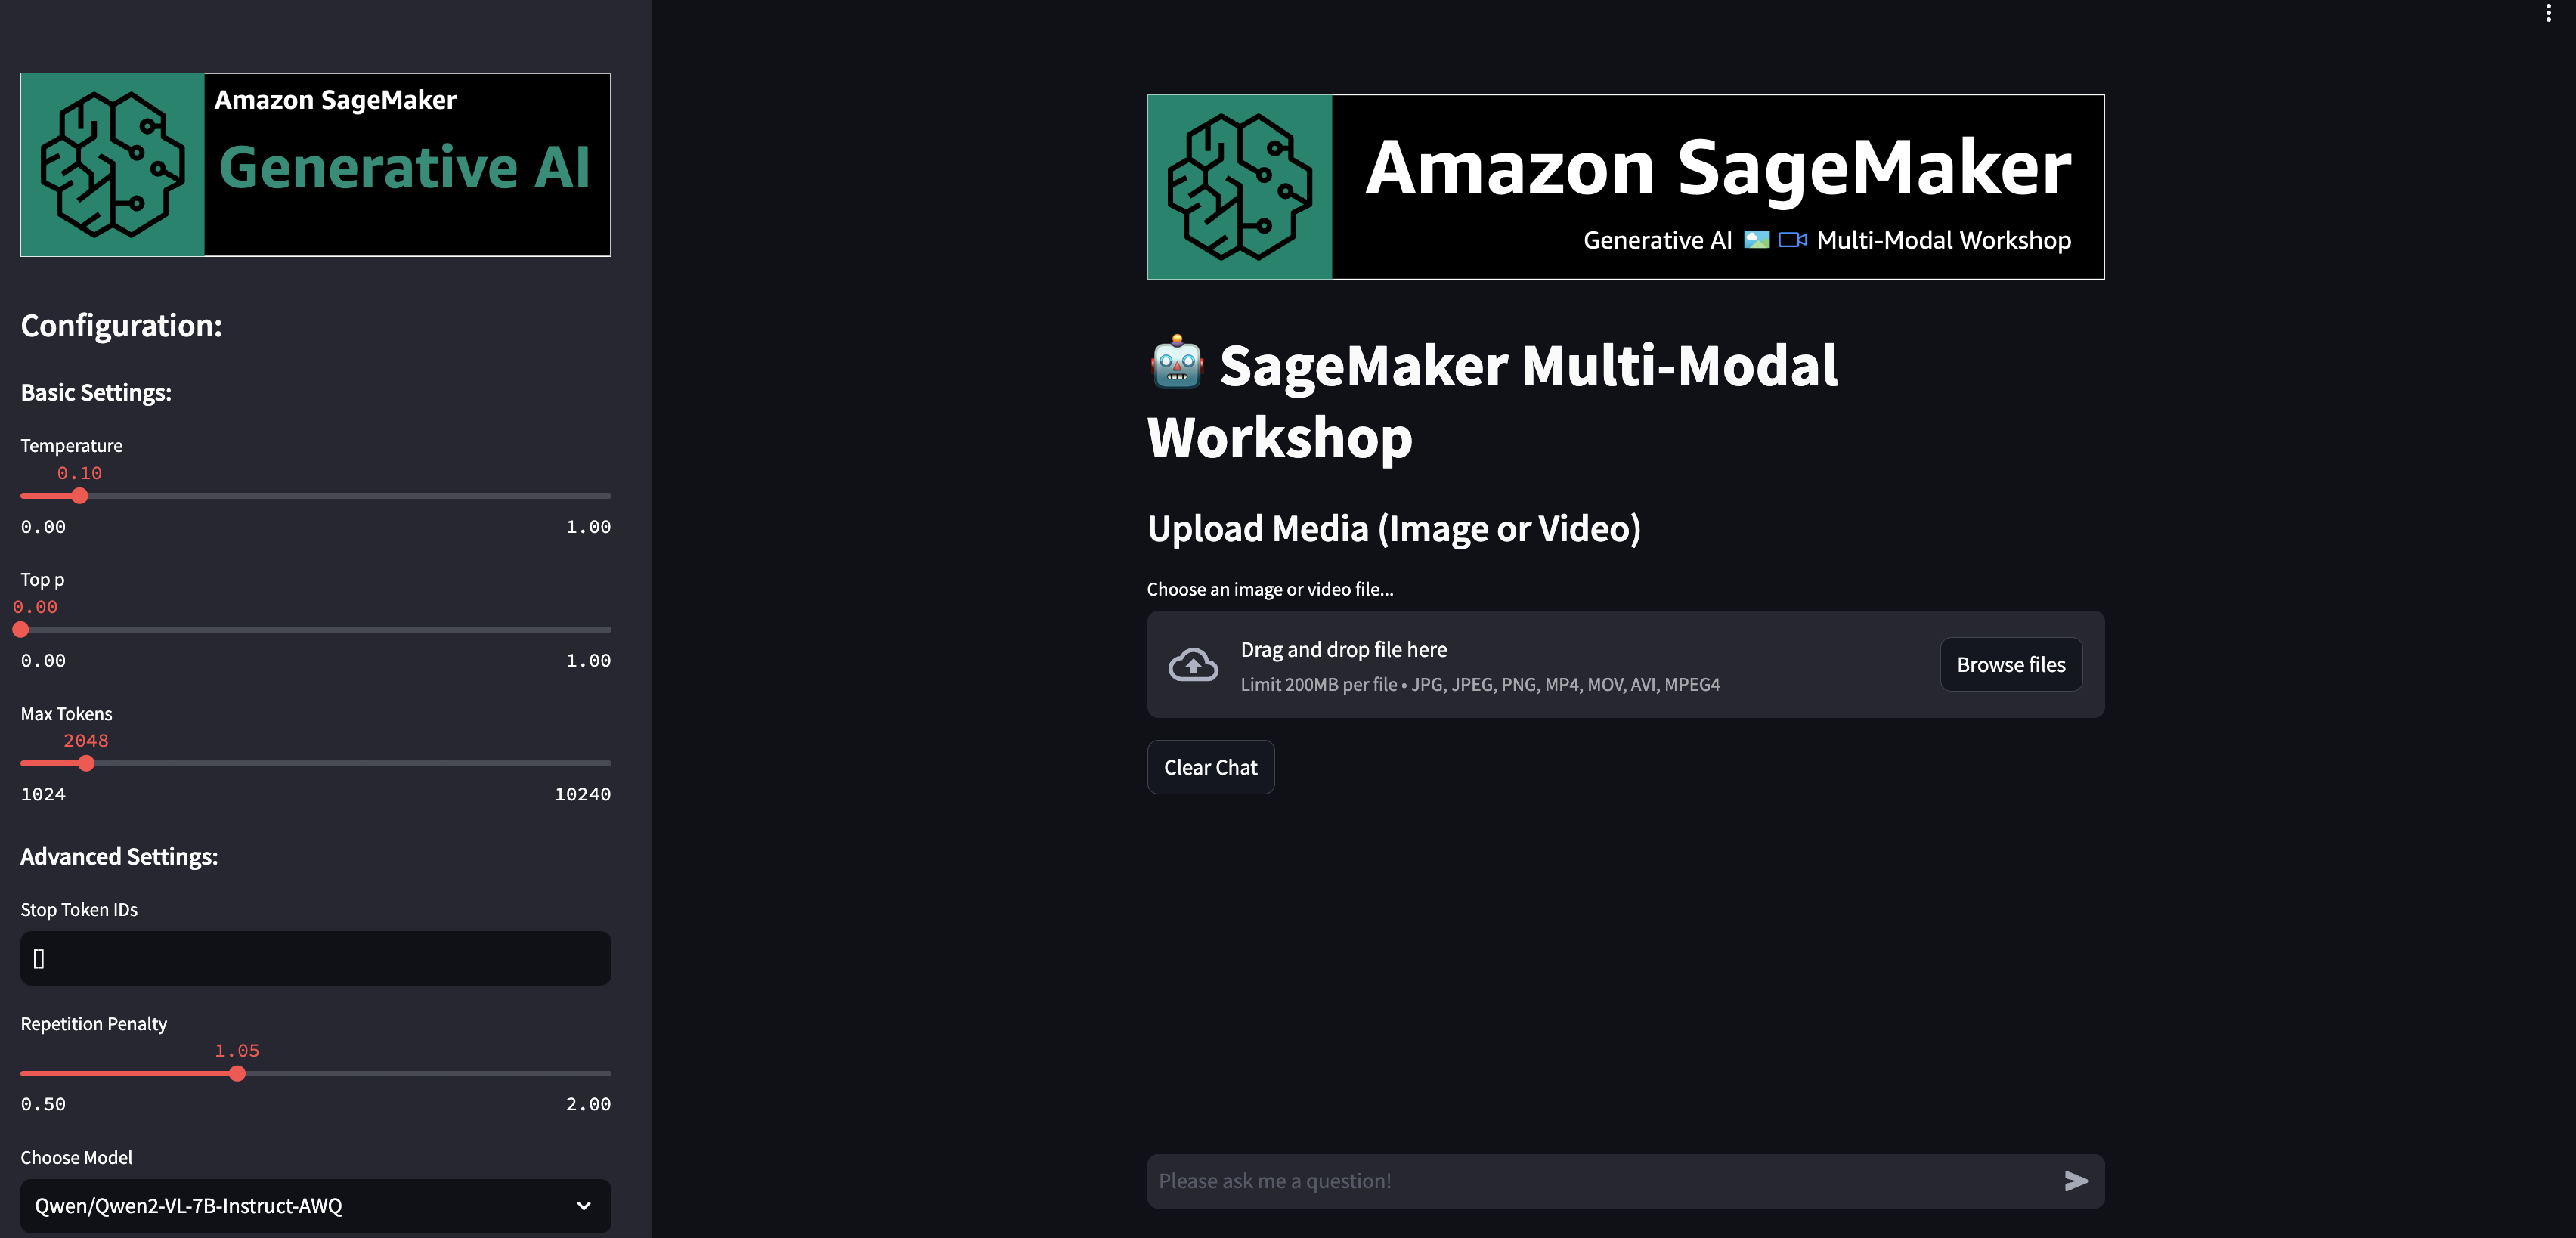

In [ ]:
%%bash

# Run the Streamlit app and push it to the background
streamlit run utils/streamlit-ui/app.py &

DOMAIN_ID=$(jq -r '.DomainId' /opt/ml/metadata/resource-metadata.json)
SPACE_NAME=$(jq -r '.SpaceName' /opt/ml/metadata/resource-metadata.json)
STREAMLIT_URL=$(aws sagemaker describe-space --domain-id $DOMAIN_ID --space-name $SPACE_NAME | jq -r '.Url')

echo "=====>  Launch Streamlit: $STREAMLIT_URL/proxy/8501/"

<div style="background-color: #ffe347; border: 2px solid #610010; padding: 10px; color: black; font-family: Arial, Helvetica, sans-serif;">
    Once you have completed the experimentation in the Streamlit UI click `Kernel > Interrupt Kernel` to stop the Streamlit UI. After that please run the cell below to free up memory.
</div>

![Kernel Interrupt](./sample-media/kernel-interrupt.png)